# Lab 7 and 8

## Jennifer Vo, lab partners with William Olsen

### Lab 7: Event Selection Optimization

## Introduction and Selection

In this lab, my partner and I will be optimizing the event selections in our LHC training samples. I will be working with the low PT training sample datasets, which come in two files: the QCD background dataset and the Higgs Boson signal dataset. There are 100k total events (jets; simulated) in each data set. The expected yield for the Higgs Boson signal data is 100 jets and the expected yield for QCD background data is 20,000 jets. (theory)

Since we will be altering the total number of data samples we are working with from 100k samples to some smaller value, the expected yields of both the signal and the background will decrease. In order to calculate this sensitivity, we will need to normalize each sample.

The ratio $R = \frac{N_{new, sim}}{N_{old,sim}}$ represents the fraction of simulated data points that we would keep after a cut, where $N_{new, sim}$ is the number of simulated data points after the cut, and $N_{old, sim}$ is the number of simulated data points before the cut.

This ratio can then be used to calculate the expected yield of a dataset after a cut:
$$N_{new, exp} = R * N_{old, exp}$$

where $N_{old, exp}$ is the expected yield before a cut.

If I substitute the ratio R into my formula for $N_{new, exp}$, I get:
$$N_{new, exp} = \frac{N_{new, sim}}{N_{old,sim}} * N_{old, exp}$$

Our expected yields are $N_{old,exp,higgs}$ = 100 Higgs signal jets and $N_{old,exp,qcd}$ = 20,000 QCD background jets, with $N_{old,sim}$ = 100,000 events for both. The fraction 100/100,000 equals 0.001 and the fraction 20,000/100,000 equals 0.2. Thus after any cuts I make on the data set I will be able to calculate the expected yields with the following formulas:

$$N_{new, exp, qcd} = N_{new, sim} * 0.2 $$
$$N_{new, exp, higgs} = N_{new, sim} * 0.001 $$

In the previous labs (Lab 5), I identified the different variables which held discrimination power between the Higgs Boson signal data and the QCD background data. In this lab, I will be plotting more histograms to work through the optimization process comprehensively. 

First let's import the required libraries for this lab and load the files' datasets into arrays that I can work with.

In [3]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import math
import pickle

# open the qcd background data file, and use pickle loading
infile = open("qcd250-500.pkl",'rb')
qcd_dict = pickle.load(infile)

# open the higgs signal data file, and use pickle loading
infile = open("higgs250-500.pkl",'rb')
higgs_dict = pickle.load(infile)

## Part 1
First, I will be working with the variable "mass". This variable represents the sum of the masses of the jet's particles, produced in the collision. I would first like to create a stacked histogram plot for mass. In this case, I will create a stacked histogram by accessing the data from each file, creating a two-dimensional array with 100,000 rows and 2 columns, which contains the mass measurement from all jet events in both the background and the Higgs signal data. Once I plot this on the stacked histogram I will distinguish them by color.

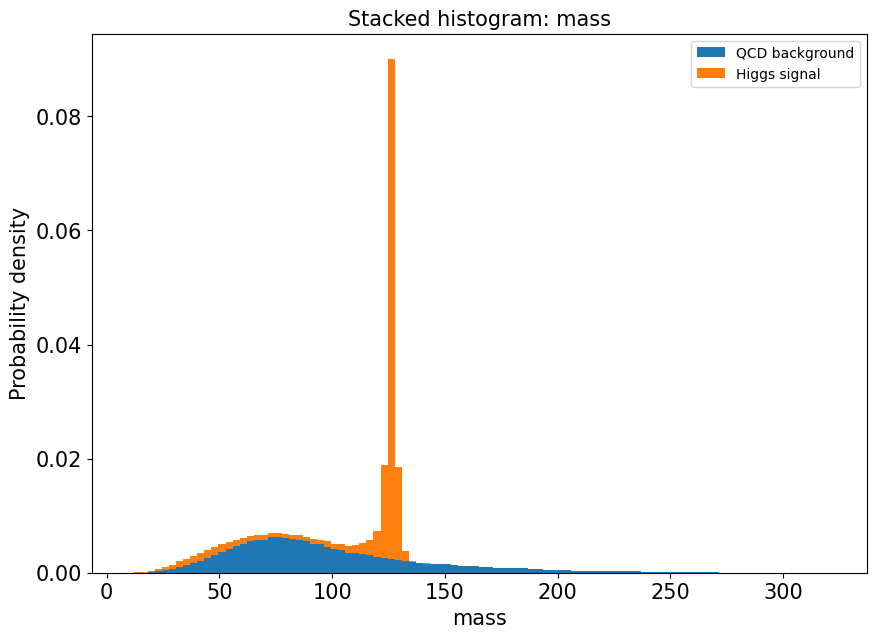

In [3]:
def plot_st_hist(var):
    w, h = 100000, 2
    combined = [[0 for x in range(w)] for y in range(h)]
    for i in range (0, 100000):
        combined[0][i] = qcd_dict[f'{var}'][i]
        combined[1][i] = higgs_dict[f'{var}'][i]

    plt.hist(combined, 100, density=True, histtype='bar', stacked=True, label=['QCD background', 'Higgs signal'])
    plt.xlabel(f'{var}', fontsize = 15)
    plt.ylabel('Probability density', fontsize = 15)
    plt.title(f'Stacked histogram: {var}', fontsize = 15)
    plt.tick_params(labelsize=15)
    plt.legend()
    plt.show()

#this sets the size of the plots to something useful
plt.rcParams["figure.figsize"] = (10,7)
plot_st_hist('mass')

As we can see, the stacked histogram plot shows that the two datasets have a similar range of values, from 0 to around 270. However, it is clear that the Higgs signal has a much greater association with mass values around approximately 125 GeV.

Next I would like to evaluate the expected significance for this initial case without any event selection. I will assume that the QCD background particle events are Poisson-distributed because the event counts are discrete with very small probabilities of occurring. The expected yield for the Higgs Boson signal data is 100 jets and the expected yield for QCD background data is 20,000 jets. Thus a measurement that is most likely to come from a true Higgs boson signal (in this dataset) would be 20,100 jets = 20,000 + 100.

Therefore, to calculate the significance I will model for the QCD background a Poisson-distribution with the average parameter $\lambda$ = 20,000 jets, and a measurement of the Higgs signal being 20,100 jets. The question is thus: __"What would be the statistical significance for the background, a Poisson distribution with $\lambda$ = 20,000 to produce a signal of 20,100 or greater?"__

Intuitively, the significance level associated with this probability would be very low, too low to be considered as a physics discovery (which requires 5 sigma). Let us calculate this:

In [10]:
def calc_sigma_poisson(lam, signal):
    prob = stats.poisson.sf(signal, lam)
    sigma = stats.norm.isf(prob)
    
    return sigma
    
def calc_signal_poisson(lam, sigma):
    prob = stats.norm.sf(sigma)
    signal = stats.poisson.isf(prob, lam)
    
    return signal
    
sigma_base = calc_sigma_poisson(20000,20100)
print(f'The significance of the background QCD particles producing a measurement of 20,100 jets is {sigma_base:.4f} sigma.')

The significance of the background QCD particles producing a measurement of 20,100 jets is 0.7112 sigma.


As predicted, the significance of this is very low, not even 1 sigma.

Let us compare this significance to the approximation $N_{Higgs}/\sqrt{N_{QCD}}$. This approximation is calculated to be $100/\sqrt{20000} = 100/141.421 \text{which approximately = } 0.7071$. This is very close to what we obtained, 0.7112. They are approximately equal but not quite. I will now explain why this is:

First, one important property of the Poisson distribution is that for large values of $\lambda$, the Poisson distribution can be approximated by a Gaussian distribution. This means we can use Gaussian statistics as an approximation for the distribution. (?)

The other important property of the Poisson distribution is that both the expected value and the variance are equal to the parameter $\lambda$. Thus, for our QCD background distribution, the parameter $\lambda = 20,000$ implies a variance of 20,000 and a standard deviation of $\sqrt{20000} = 141.421$, this is what is the denominator of the approximation $N_{Higgs}/\sqrt{N_{QCD}}$.

Putting these two facts together, we see that a deviation of 100 from the mean of the background distribution (20,000) would be $\frac{100}{141.421} \sigma$ or approximately $0.7071 \sigma$ away from the mean.

## Part 2
Now that we have established the baseline significance I would like to optimize the expected significance by identifying first the best cut of the mass data. We saw that the Higgs signal is strongly associated with a mass around 125 GeV, but ranges between around 25 and 140 GeV. Therefore I will explore cuts around this value.

I will make cuts incrementally and compute the expected significance for each one, then determine which cut results in the highest significance. To start, I will make a first cut to keep data in the range of 100 and 150 GeV, then narrow it down to smaller windows in increments of 5 GeV from both sides symmetrically to approach 125 GeV.

In [5]:
def slice_data(qcd, higgs, var, low, high, toReturn):
    # slice qcd
    ind_qcd_below = qcd[qcd[f'{var}'] < low].index
    ind_qcd_above = qcd[qcd[f'{var}'] > high].index
    new_qcd = qcd.drop(ind_qcd_below)
    new_qcd = new_qcd.drop(ind_qcd_above)
    
    # slice higgs
    ind_higgs_below = higgs[higgs[f'{var}'] < low].index
    ind_higgs_above = higgs[higgs[f'{var}'] > high].index
    new_higgs = higgs.drop(ind_higgs_below)
    new_higgs = new_higgs.drop(ind_higgs_above)
    
    # calc new expected yields of qcd and higgs using the ratio a = 0.2 and b = 0.001 (calculated in introduction)
    a = 0.2
    b = 0.001
    y_qcd = int(a * len(new_qcd))
    perc_qcd = len(new_qcd) / 100000
    y_higgs = int(b * len(new_higgs))
    perc_higgs = len(new_higgs) / 100000
    
    #finally, calc new significance
    sigma = calc_sigma_poisson(y_qcd, y_qcd + y_higgs)
    
    if toReturn:
        return new_qcd, new_higgs, y_qcd, y_higgs, sigma, perc_qcd, perc_higgs
    else:
        return (f'Slicing data to keep range {low} to {high} GeV... The statistical significance of a yield of {y_higgs} jets is {sigma:.4f} sigma.')

print(slice_data(qcd_dict, higgs_dict, 'mass', 0, 300, False)) # check -> process is correct
print(slice_data(qcd_dict, higgs_dict, 'mass', 100, 150, False))
print(slice_data(qcd_dict, higgs_dict, 'mass', 105, 145, False))
print(slice_data(qcd_dict, higgs_dict, 'mass', 110, 140, False))
print(slice_data(qcd_dict, higgs_dict, 'mass', 115, 135, False))
print(slice_data(qcd_dict, higgs_dict, 'mass', 120, 130, False))

Slicing data to keep range 0 to 300 GeV... The statistical significance of a yield of 100 jets is 0.7113 sigma.
Slicing data to keep range 100 to 150 GeV... The statistical significance of a yield of 84 jets is 1.1731 sigma.
Slicing data to keep range 105 to 145 GeV... The statistical significance of a yield of 84 jets is 1.3247 sigma.
Slicing data to keep range 110 to 140 GeV... The statistical significance of a yield of 82 jets is 1.4987 sigma.
Slicing data to keep range 115 to 135 GeV... The statistical significance of a yield of 81 jets is 1.8211 sigma.
Slicing data to keep range 120 to 130 GeV... The statistical significance of a yield of 75 jets is 2.3870 sigma.


As we can see the best cut corresponds to that between a low of 120 GeV and a high of 130 GeV, where we cut down from 100 jets to 75. This corresponds with an expected significance of 2.3870$\sigma$.

In [7]:
perc_qcd_mass_cut = slice_data(qcd_dict, higgs_dict, 'mass', 120, 130, True)[5]
perc_higgs_mass_cut = slice_data(qcd_dict, higgs_dict, 'mass', 120, 130, True)[6]
print(f'The percentage of qcd background data that the mass cut kept is {perc_qcd_mass_cut*100:.2f}% of the original dataset.')
print(f'The percentage of higgs data that the mass cut kept is {perc_higgs_mass_cut*100:.2f}% of the original dataset.')

The percentage of qcd background data that the mass cut kept is 4.90% of the original dataset.
The percentage of higgs data that the mass cut kept is 75.85% of the original dataset.


## Part 3
Now that we have the results from slicing the datasets based on the mass feature, I would like to plot stacked histograms for each of the features. For each feature, Set A will consist of stacked histograms without any event selection, and Set B will consist of stacked histograms with my mass cut, keeping only that data with the mass feature within the range of 120-130 GeV.

After plotting, I will make observations.

In [8]:
# def function to plot stacked histograms before (set A) and after (set B) optimal mass cut
def plot_comparison(qcd, higgs, qcd_sliced, higgs_sliced, var, var_slice):
    combined = [qcd[f'{var}'], higgs[f'{var}']]

    plt.subplot(2,1,1)
    plt.hist(combined, 100, density=True, histtype='bar', stacked=True, label=['QCD background', 'Higgs signal'])
    plt.xlabel(f'{var}', fontsize = 13)
    plt.ylabel('Probability density', fontsize = 15)
    plt.title(f'Stacked histogram: {var}', fontsize = 13)
    plt.tick_params(labelsize=15)
    plt.legend()
    
    combined_sliced = [qcd_sliced[f'{var}'], higgs_sliced[f'{var}']]
    
    plt.subplot(2,1,2)
    plt.hist(combined_sliced, 100, density=True, histtype='bar', stacked=True, label=['QCD background', 'Higgs signal'])
    plt.xlabel(f'{var}', fontsize = 13)
    plt.ylabel('Probability density', fontsize = 15)
    plt.title(f'Stacked histogram: {var} with {var_slice} cut', fontsize = 13)

    plt.tick_params(labelsize=15)
    plt.legend()
    plt.show()

output = slice_data(qcd_dict, higgs_dict, 'mass', 120, 130, True)
plt.rcParams["figure.figsize"] = (10,12)

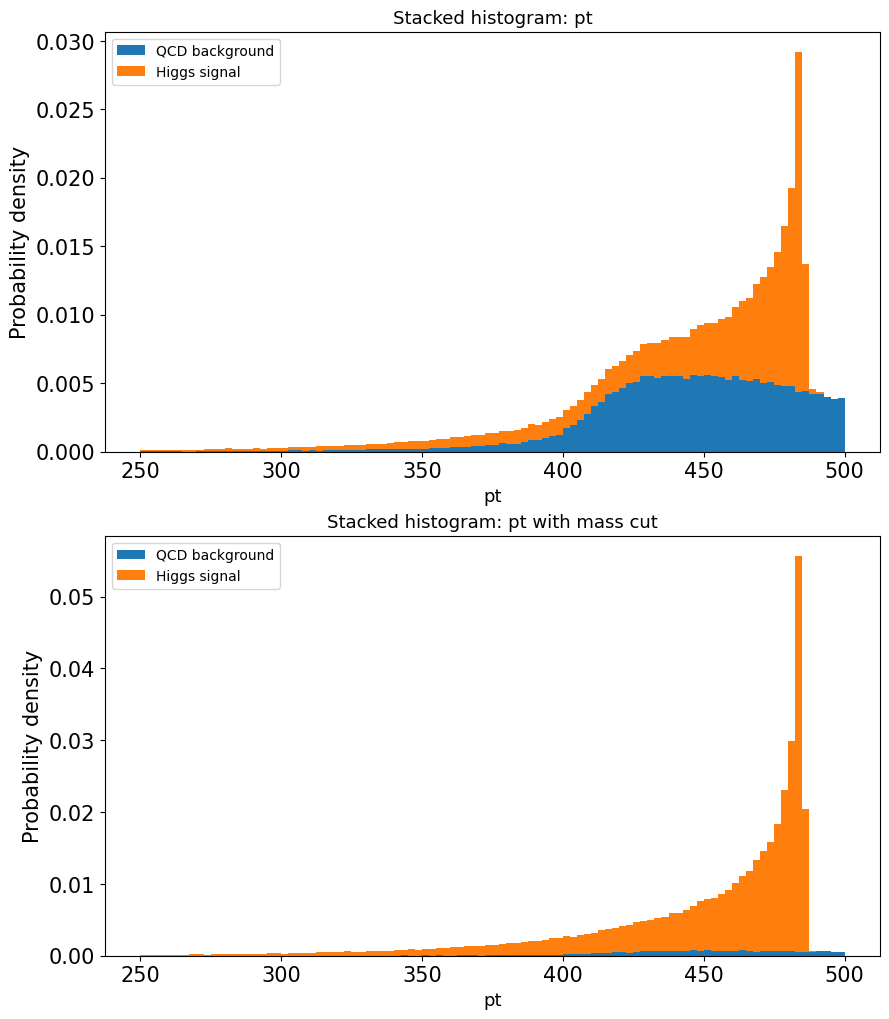

In [9]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'pt', 'mass')

With pt, I observe that the feature's Set A plot has Higgs signal and QCD background data in approximately the same range. This suggests there is low discriminatory power for slicing based on pt.

The pt Set B plot shows the stacked histogram of the datasets after the mass cut. I don't see a way to improve upon the expected significance by making a further cut on pt as the data range significantly overlaps.

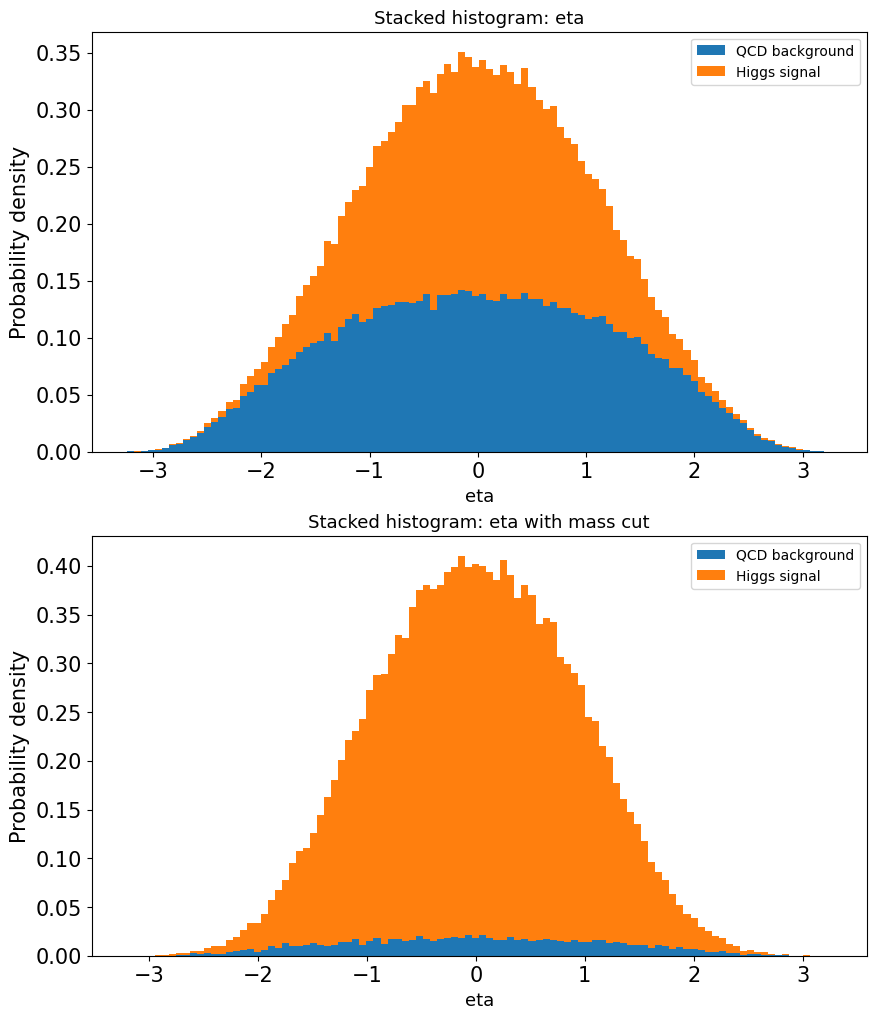

In [10]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'eta', 'mass')

With eta, I observe that the feature's Set A plot has Higgs signal and QCD background data in approximately the same range. This suggests there is low discriminatory power for slicing based on eta.

The eta Set B plot shows the stacked histogram of the datasets after the mass cut. I don't see a way to improve upon the expected significance by making a further cut on eta as the data range entirely overlaps.

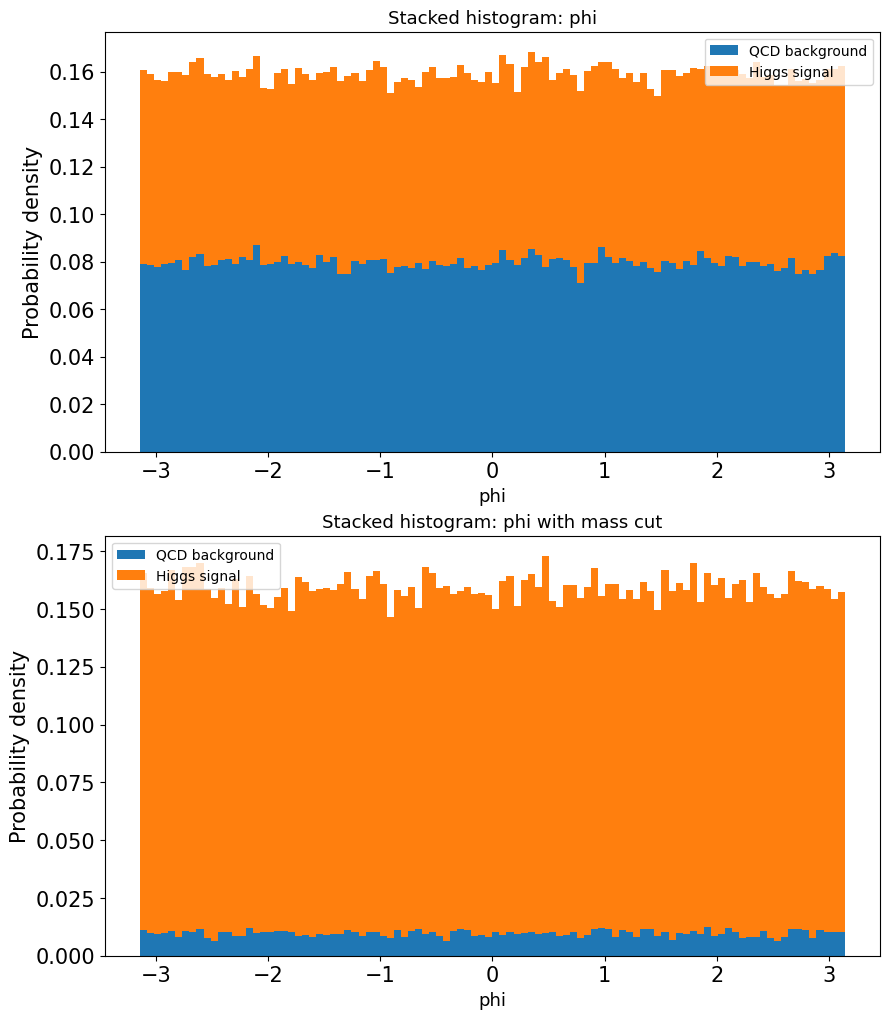

In [11]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'phi', 'mass')

With phi, I observe that the feature's Set A plot has Higgs signal and QCD background data in approximately the same range, in addition to the data composition looking almost identical. This suggests there is very low discriminatory power for slicing based on phi.

The phi Set B plot shows the stacked histogram of the datasets after the mass cut. I don't see a way to improve upon the expected significance by making a further cut on phi as the data range entirely overlaps.

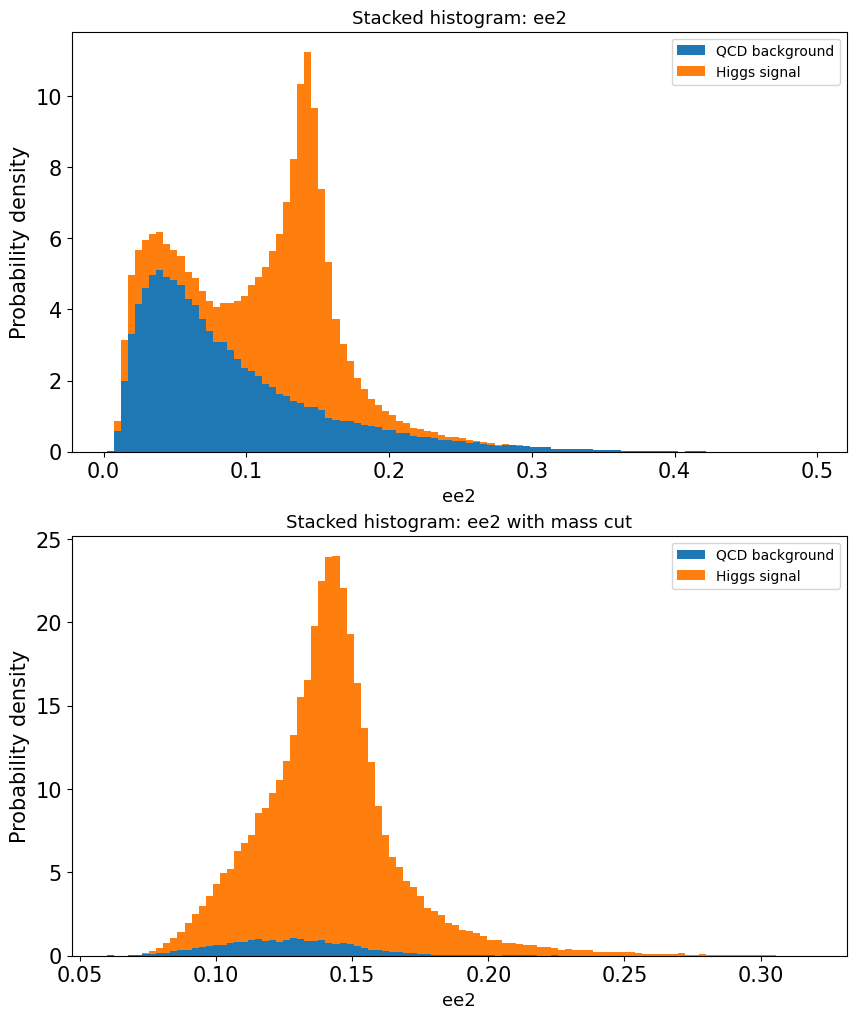

In [12]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'ee2', 'mass')

With ee2, I observe that the feature's Set A plot has Higgs signal and QCD background data in approximately the same range, however the peak for the Higgs signal is noticeably different from that of the QCD background data. This suggests there is some discriminatory power for slicing based on ee2. I could make a slice of data to keep that in the range of 0.1 to 0.2 while cutting out the majority of the background data and keeping the majority of the Higgs signal data.

The ee2 Set B plot shows the stacked histogram of the datasets after the mass cut. The Higgs signal and QCD background data overlap significantly, therefore I don't think I could improve upon the expected significance by making a further cut on ee2.

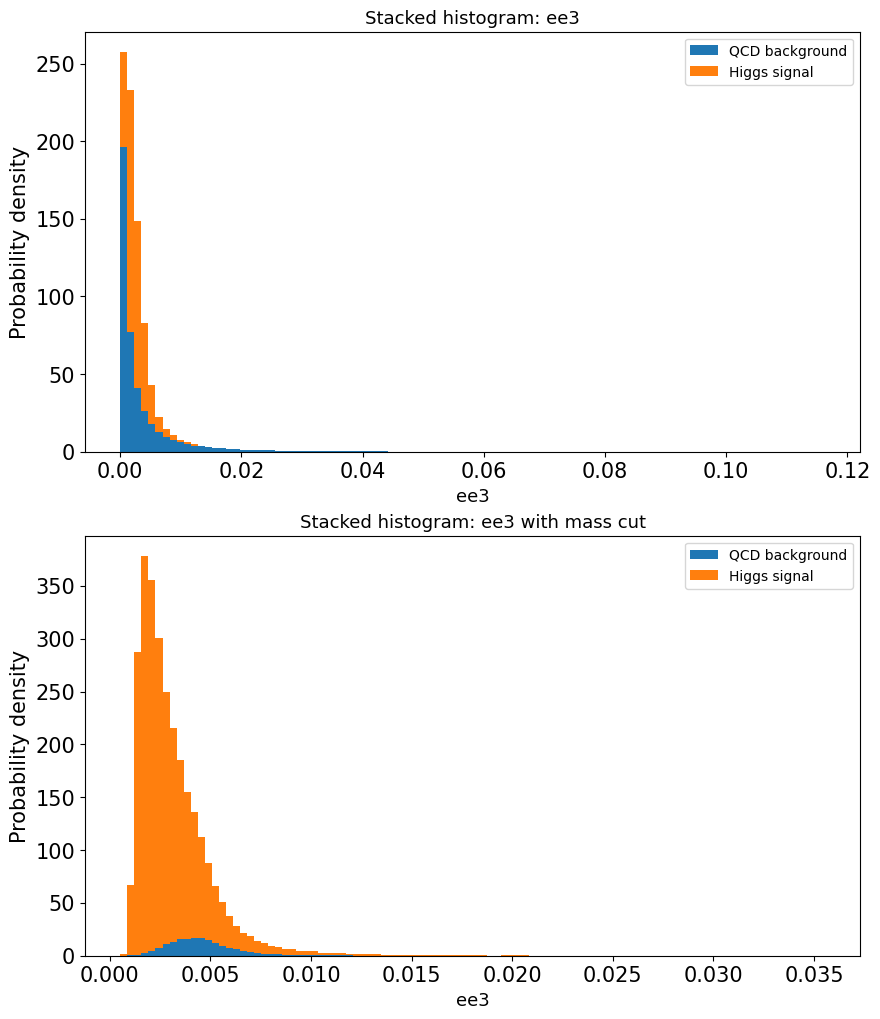

In [13]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'ee3', 'mass')

With ee3, I observe that the feature's Set A plot has Higgs signal and QCD background data in almost exactly the same range, suggesting there is very low discriminatory power for slicing based on ee3.

The ee3 Set B plot shows the stacked histogram of the datasets after the mass cut. I don't see a way to improve upon the expected significance by making a further cut on ee3 as the data range significantly overlaps.

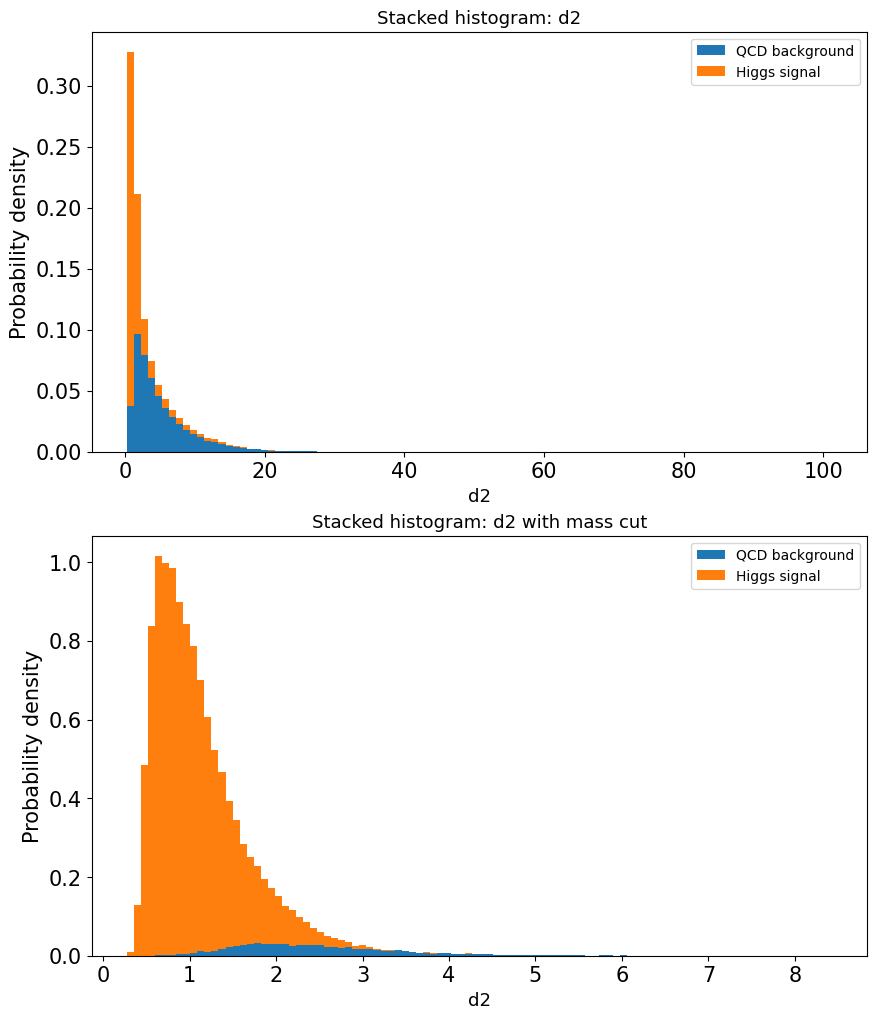

In [14]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'd2', 'mass')

With d2, I observe that the feature's Set A plot has Higgs signal and QCD background data in almost exactly the same range, suggesting there is very low discriminatory power for slicing based on d2.

The d2 Set B plot shows the stacked histogram of the datasets after the mass cut. We can improve upon the expected significance by making a further cut on d2: consider, for example, a further slice of the data to keep only that which has d2 within the range of 0 and 2.5. This would keep the majority of the Higgs data while removing the majority of the QCD background data.

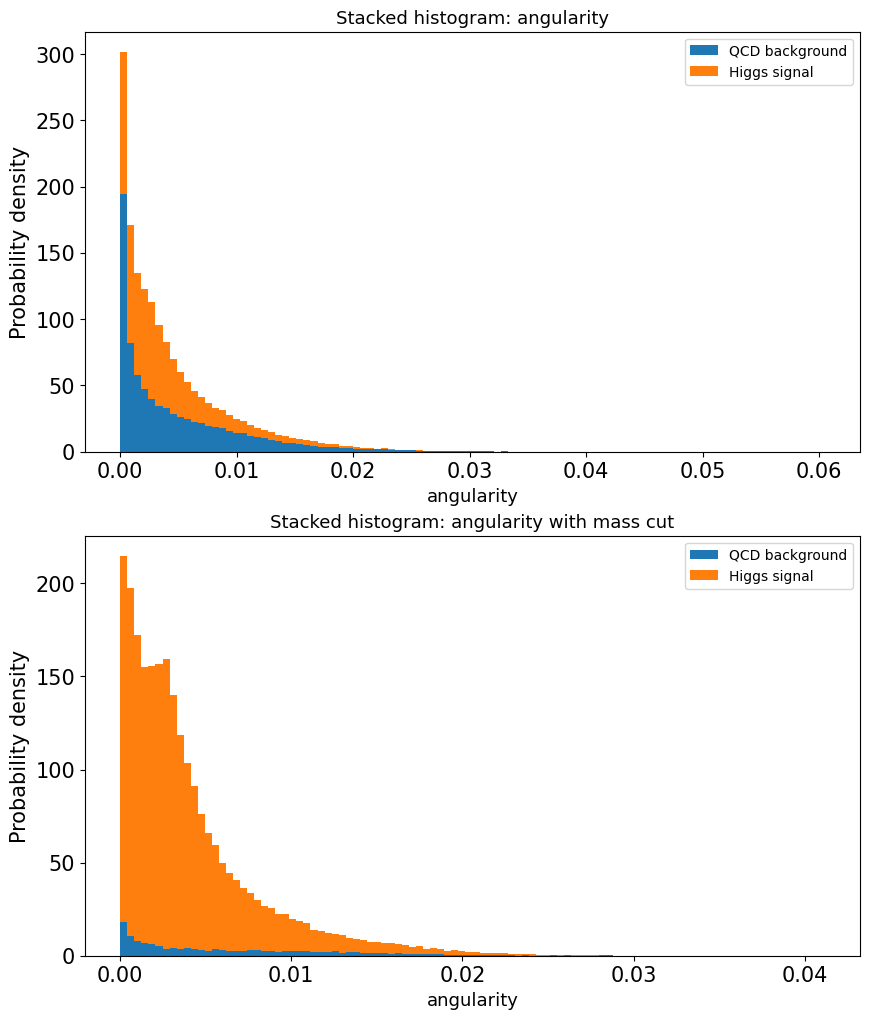

In [15]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'angularity', 'mass')

With angularity, I observe that the feature's Set A plot has Higgs signal and QCD background data in almost exactly the same range, suggesting there is very low discriminatory power for slicing based on angularity.

The angularity Set B plot shows the stacked histogram of the datasets after the mass cut. I don't see a way to improve upon the expected significance by making a further cut on angularity as the data range entirely overlaps.

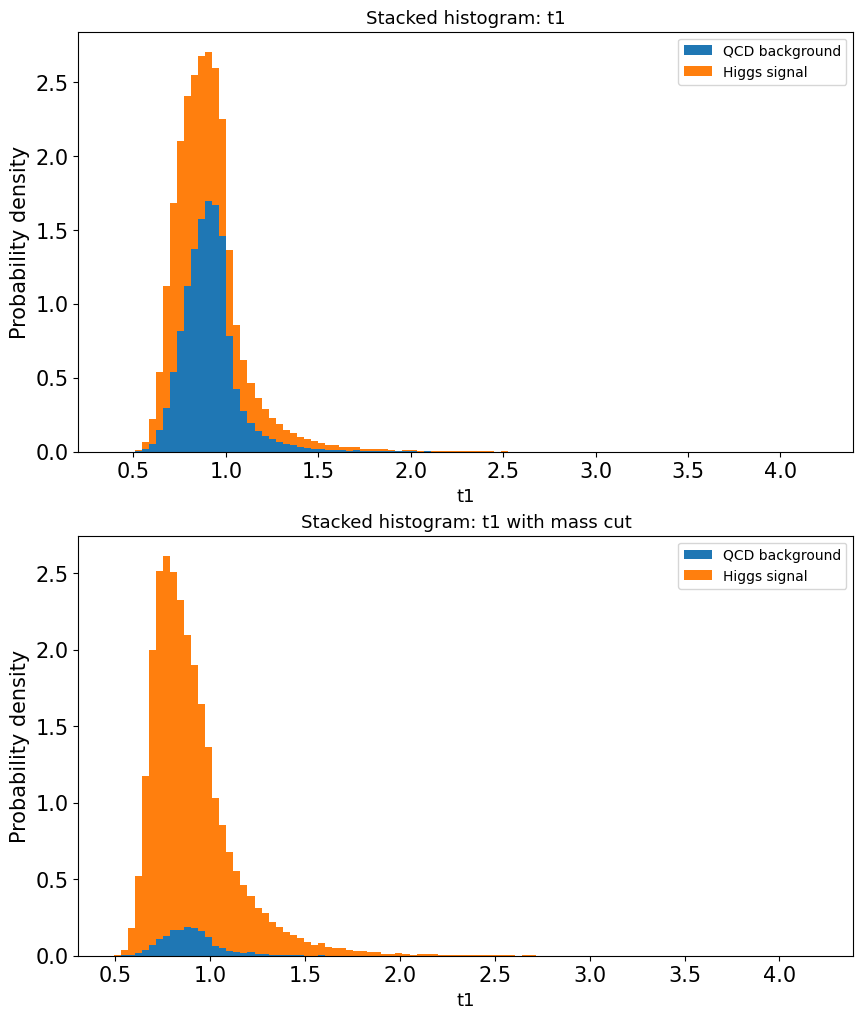

In [16]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 't1', 'mass')

With t1, I observe that the feature's Set A plot has Higgs signal and QCD background data in almost exactly the same range, suggesting there is very low discriminatory power for slicing based on t1.

The t1 Set B plot shows the stacked histogram of the datasets after the mass cut. I don't see a way to improve upon the expected significance by making a further cut on t1 as the data range significantly overlaps.

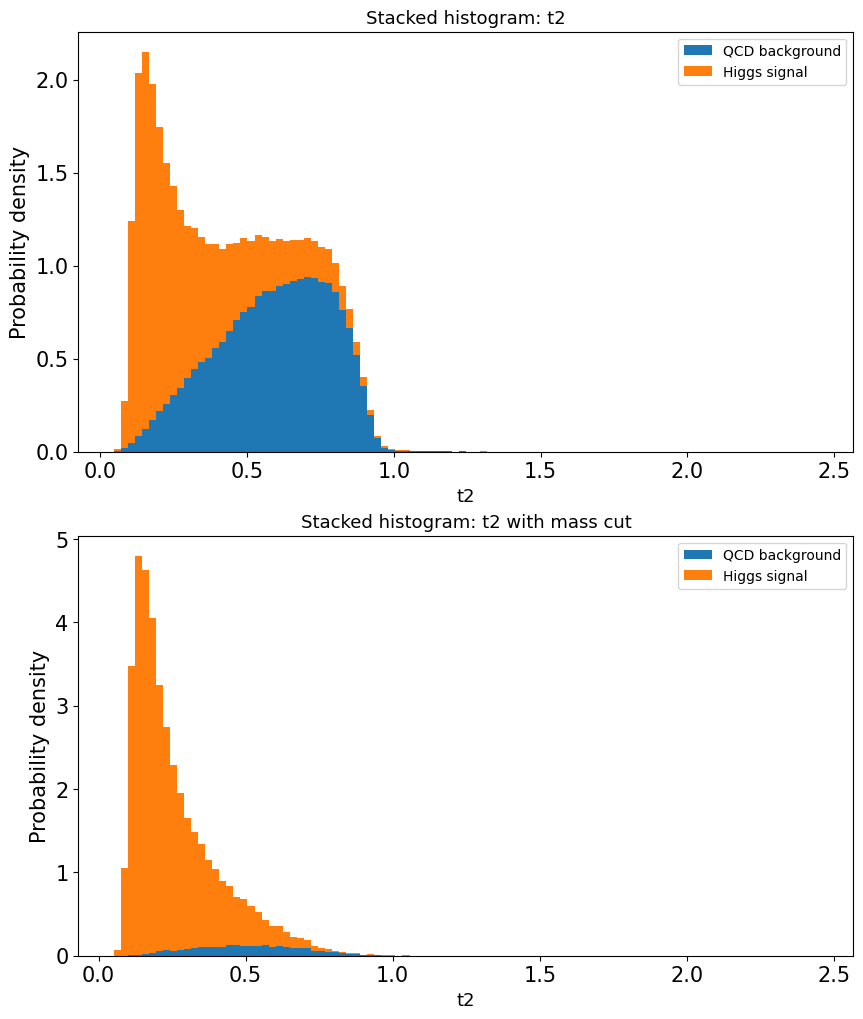

In [17]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 't2', 'mass')

With t2, I observe that the feature's Set A plot shows Higgs signal and QCD background data with two very different peaks. The Higgs signal data peaks around 0.1, while the QCD background peaks around 0.75. There is some discriminatory power for slicing based on t2, for example we could make a slice to keep data only within the range of 0 and 0.5 (but we may lose a fraction of the Higgs signal data).

The t2 Set B plot shows the stacked histogram of the datasets after the mass cut. To improve upon the expected significance, I can make a further cut on t2 by slicing to keep data only within the range of 0 and 0.5, same as for Set A.

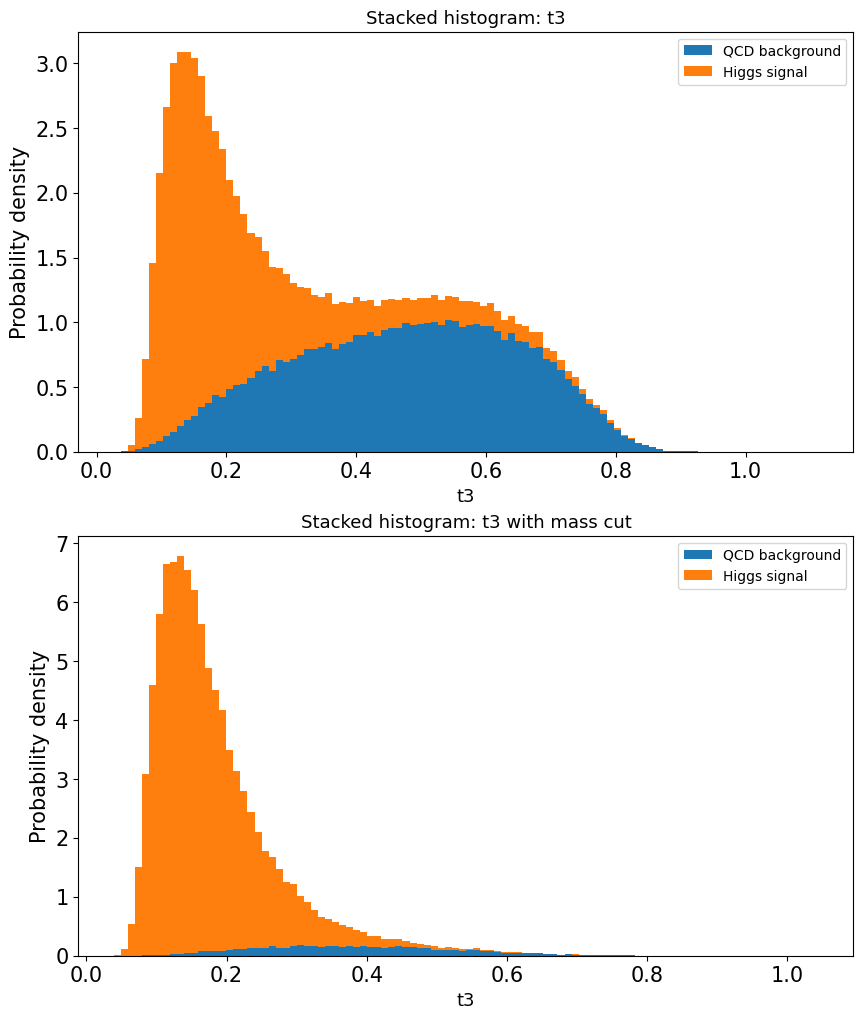

In [18]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 't3', 'mass')

With t3, I observe that the feature's Set A plot shows Higgs signal and QCD background data with two very different peaks. The Higgs signal data peaks around 0.15, while the QCD background peaks around 0.5. There is some discriminatory power for slicing based on t3, for example we could make a slice to keep data only within the range of 0 and 0.5 (but we may lose a fraction of the Higgs signal data).

The t3 Set B plot shows the stacked histogram of the datasets after the mass cut. To improve upon the expected significance, I can make a further cut on t3 by slicing to keep data only within the range of 0 and 0.5, same as for Set A.

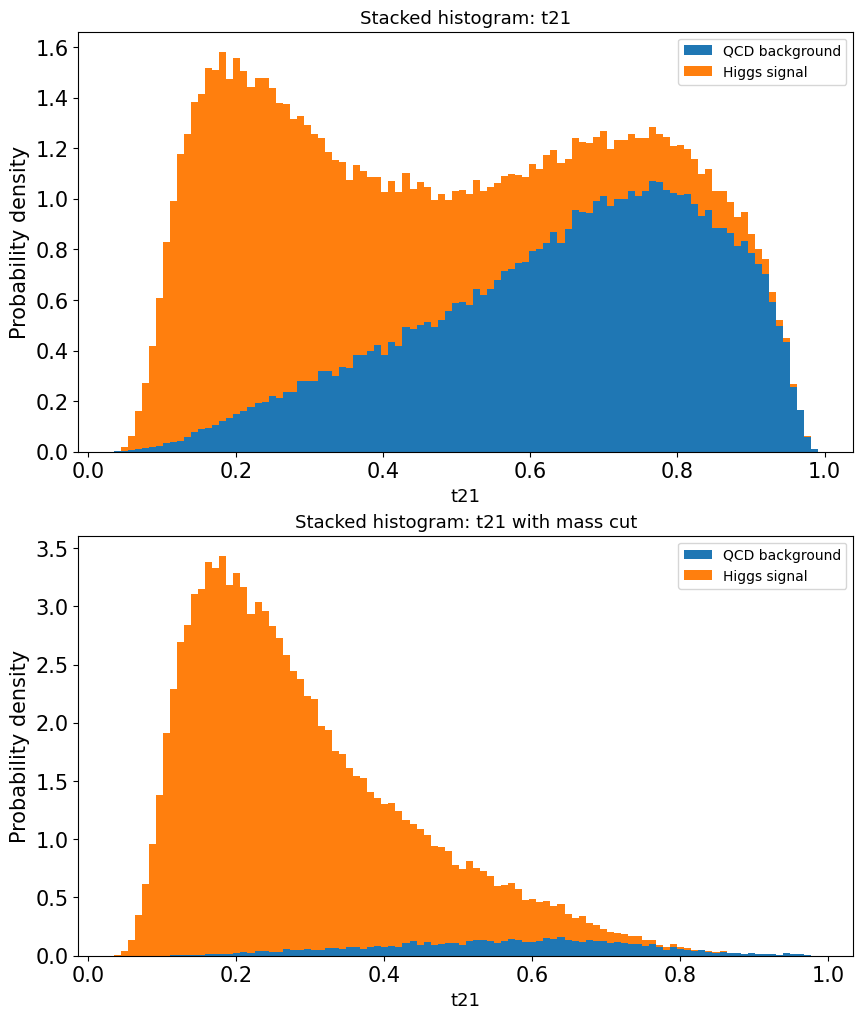

In [19]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 't21', 'mass')

With t21, I observe that the feature's Set A plot shows Higgs signal and QCD background data with two very different peaks. The Higgs signal data peaks around 0.2, while the QCD background peaks around 0.8. There is some discriminatory power for slicing based on t21, for example we could make a slice to keep data only within the range of 0 and 0.6 (but we may lose a fraction of the Higgs signal data).

The t21 Set B plot shows the stacked histogram of the datasets after the mass cut. To improve upon the expected significance, I can make a further cut on t21 by slicing to keep data only within the range of 0 and 0.6, same as for Set A. This would remove approximately half of the qcd background data.

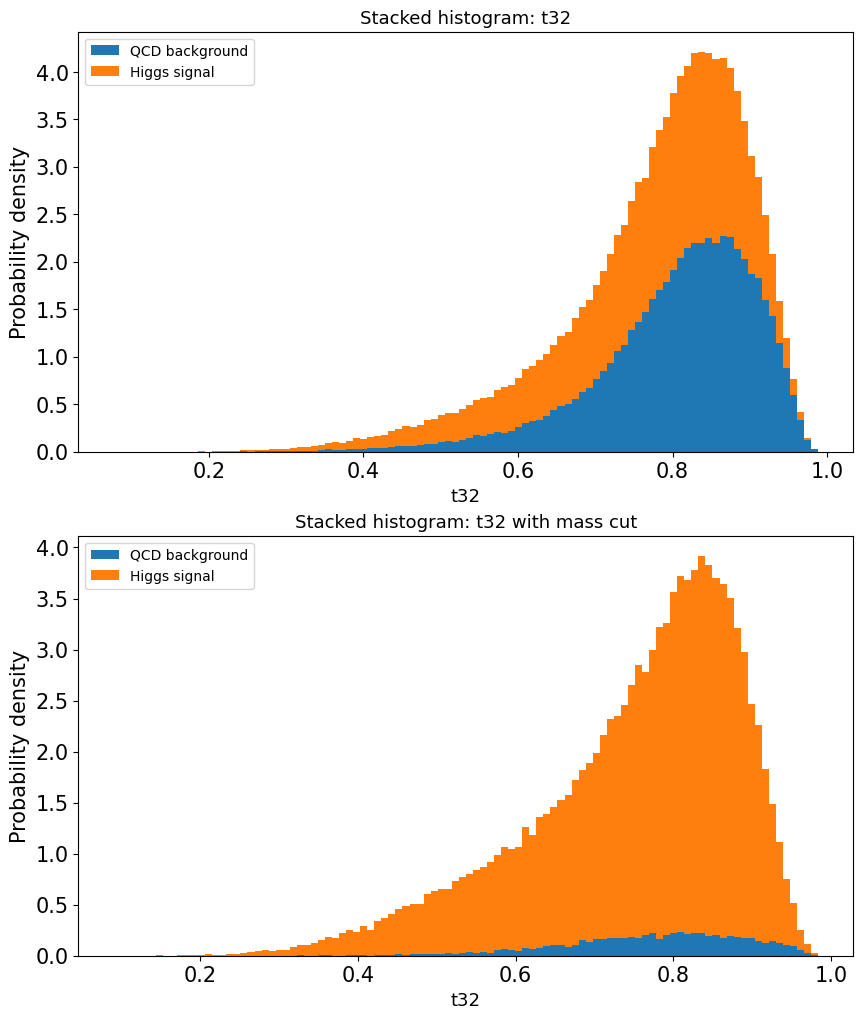

In [20]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 't32', 'mass')

With t32, I observe that the feature's Set A plot shows Higgs signal and QCD background data with overlapping peaks at approximately 0.85. There is very low discriminatory power for slicing based on t32.

The t32 Set B plot shows the stacked histogram of the datasets after the mass cut. I don't see a way to improve upon the expected significance by making a further cut on t32 as the data range entirely overlaps.

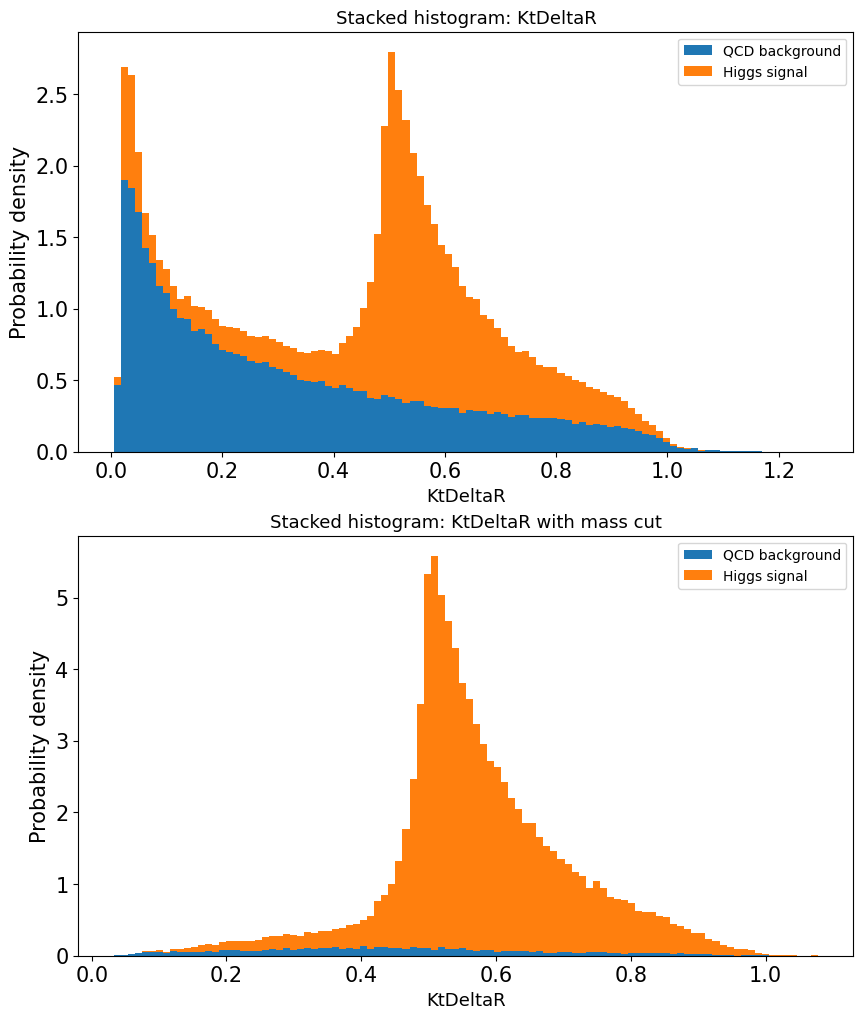

In [21]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'KtDeltaR', 'mass')

With KtDeltaR, I observe that the feature's Set A plot shows Higgs signal and QCD background data with one small overlapping peak at approximately 0.05, and an additional peak in the Higgs signal data around 0.5. There is some discriminatory power for slicing based on KtDeltaR. Consider a slice that keeps data where KtDeltaR is between 0.4 and 1.0. This would keep the majority of the Higgs signal data while removing around half of the background data.

The KtDeltaR Set B plot shows the stacked histogram of the datasets after the mass cut. To improve upon the expected significance I can make a further cut on KtDeltaR by slicing to keep data within the range of 0.4 and 1.0. As in Set A, this would keep the majority of the Higgs signal data while removing around half of the background data.

##### Summary of Observations
Set A plots with very little or no discriminatory power include pt, eta, phi, ee3, d2, angularity, t1, and t32.

Set A plots with some discriminatory power, but less than mass include ee2, t2, t3, t21, KtDeltaR. I found that no Set A plots had equal discriminatory power as mass. With the feature cut on mass, I was able to remove 95.1% of the QCD background data with my slicing, however with the other plots with some discriminatory power between the Higgs signal and the QCD background data, I could only remove at maximum around half of the QCD background while keeping an adequate portion of Higgs signal data.

From the Set B plot observations, I identified that making further slices on the features of d2, angularity, t2, t3, t21, and KtDeltaR after the initial cut on mass would each improve my expected significance.

## Part 4
Next, I will use multiple features to optimize event selections. I will take the information I obtained in Part 3 to make further cuts on the mass-sliced data. My goal is to achieve a significance of 5 sigma.

I will start by making a further slice on the feature of d2. Afterwards, if I still have not reached 5 sigma significance I will decide then to make further cuts (on 1 of the 4 leftover variables). If I have reached 5 sigma significance, then there is no need to go further.

In [22]:
# Recall for the mass cut we used, data is stored in the variable 'output' in the following order:
    # new_qcd, new_higgs, y_qcd, y_higgs, sigma, perc_qcd, perc_higgs

def slice_mass_on_d2(low_d2, high_d2):
    output_d2 = slice_data(output[0], output[1], 'd2', low_d2, high_d2, True)
    print(f'For a d2 cut keeping data between {low_d2} and {high_d2}, I obtain a significance of {output_d2[4]:.4f} sigma.')
    print(f'Higgs % data kept: {output_d2[6]*100:.2f}%')
    print(f'Background % kept: {output_d2[5]*100:.2f}%')

slice_mass_on_d2(0,2.5)
slice_mass_on_d2(0,2)
slice_mass_on_d2(0,1.8)
slice_mass_on_d2(0,1.5)
slice_mass_on_d2(0,1.6)
slice_mass_on_d2(0,1.56)

For a d2 cut keeping data between 0 and 2.5, I obtain a significance of 3.0474 sigma.
Higgs % data kept: 74.87%
Background % kept: 2.88%
For a d2 cut keeping data between 0 and 2, I obtain a significance of 3.6856 sigma.
Higgs % data kept: 71.76%
Background % kept: 1.78%
For a d2 cut keeping data between 0 and 1.8, I obtain a significance of 4.1766 sigma.
Higgs % data kept: 69.22%
Background % kept: 1.28%
For a d2 cut keeping data between 0 and 1.5, I obtain a significance of 5.3490 sigma.
Higgs % data kept: 63.12%
Background % kept: 0.61%
For a d2 cut keeping data between 0 and 1.6, I obtain a significance of 4.8464 sigma.
Higgs % data kept: 65.64%
Background % kept: 0.82%
For a d2 cut keeping data between 0 and 1.56, I obtain a significance of 5.0317 sigma.
Higgs % data kept: 64.70%
Background % kept: 0.73%


I started with my initial range guess of 0 to 2.5, then manually selected narrower ranges to optimize my sigma value. While maximizing my significance is one goal, the other goal is to keep as much of the Higgs signal data as I could.

Eventually I found that the optimal cut for a sigma over 5 while keeping as much Higgs data % of the original simulation data as I could is to keep the data where d2 values are between 0 and 1.56. This results in a significance of 5.0317 which keeps 64.7% of the original Higgs dataset and 0.73% of the original QCD background.

##### Comparison of Significance with William Olsen
My lab partner William Olsen used a different pT sample dataset. He started with 100k QCD background events and 100k Higgs signal events as well, all simulated. However, he had different expected yields before cutting; William's datasets had 50 expected Higgs signal events and 2000 expected QCD background events. He calculated an initial significance of 1.1282 sigma. After slicing his dataset on the features of mass, t3, then KtDeltaR in this order, he was able to optimize his significance to 5.5542 sigma, keeping 90.37% of the Higgs dataset he originally had, and 2.73% of the initial QCD background.

In comparison, both William and I were able to optimize our event selections to obtain significance over 5 sigma, the discovery threshold that is standard in physics. However, William was able to preserve 90.37% of the Higgs signal data, much greater than the 64.7% of my Higgs signal data.

# Lab 8: Pseudo-experiment data analysis

## Introduction

In this lab, we will use the optimized event selection found in Lab 7 to hunt for my signal with the pseudo-experiment datasets. These come in two files: one that contains high luminosity data, and one for low luminosity data. 

The high luminosity data is associated with a higher number of collisions that occur in a given amount of time than the low luminosity data.

First, we'll need to load the pseudo-experiment data. I use the library pandas to read the hdf files.

In [71]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import math
import pickle

# open the qcd background data file, and use pickle loading
infile = open("qcd250-500.pkl",'rb')
qcd_dict = pickle.load(infile)

# open the higgs signal data file, and use pickle loading
infile = open("higgs250-500.pkl",'rb')
higgs_dict = pickle.load(infile)

import pandas
highLumi = pandas.read_hdf('data_highLumi_pt_250_500.h5')
lowLumi = pandas.read_hdf('data_lowLumi_pt_250_500.h5')

# set fig size
plt.rcParams["figure.figsize"] = (10,10)

## Part 1
__- For each feature of your event selection, plot the observed data overlapped with expected signal and background (normalized to observed yields) with/without event selection.__

For each feature of my event selection (mass and d2), I will plot the observed data and overlap this with a plot of the expected signal and background data (as a stacked histogram) which are normalized to the observed yields. I will do this before event selection and after to show the effect of my event selection.

Afterward, I will evaluate the observed significance that results and compare my results to the expectation. 

We'll start with the high luminosity dataset first. Let's see how many events are included in this dataset.

In [72]:
N_highLumi = len(highLumi) 
print(N_highLumi) #40344

40344


The high luminosity dataset has 40,344 events recorded.

To overlap the plots, I will need to take my qcd and higgs data and scale it by two factors: 
- one to reflect the ratio of the expected yields of the higgs signal to the qcd background: 100/20,100 and 20,000/20,100 respectively
- one to normalize the expected signal and background data to the observed yields. This will be the same ratio for both: 40,344/100,000 such that the plots reflect the same number of total events (observed and expected are the same).

My event selection as determined in Lab 7 uses two features: mass and d2. I will plot the observed high luminosity data for both of these features overlapped with the expected signal and background, before and after event selection.

First I will start with mass:

In [85]:
def calc_sigma_poisson(lam, signal):
    prob = stats.poisson.sf(signal, lam)
    sigma = stats.norm.isf(prob)
    
    return sigma

def slice_data(qcd, higgs, lumi, var, low, high, toReturn):
    # slice qcd
    ind_qcd_below = qcd[qcd[f'{var}'] < low].index
    ind_qcd_above = qcd[qcd[f'{var}'] > high].index
    new_qcd = qcd.drop(ind_qcd_below)
    new_qcd = new_qcd.drop(ind_qcd_above)
    
    # slice higgs
    ind_higgs_below = higgs[higgs[f'{var}'] < low].index
    ind_higgs_above = higgs[higgs[f'{var}'] > high].index
    new_higgs = higgs.drop(ind_higgs_below)
    new_higgs = new_higgs.drop(ind_higgs_above)
    
    # slice lumi
    ind_lumi_below = lumi[lumi[f'{var}'] < low].index
    ind_lumi_above = lumi[lumi[f'{var}'] > high].index
    new_lumi = lumi.drop(ind_lumi_below)
    new_lumi = new_lumi.drop(ind_lumi_above)
    
    # calc new expected yields of qcd and higgs using the ratio a = 0.2 and b = 0.001 (calculated in introduction)
    a = 0.2
    b = 0.001
    y_qcd = int(a * len(new_qcd))
    perc_qcd = len(new_qcd) / len(qcd)
    y_higgs = int(b * len(new_higgs))
    perc_higgs = len(new_higgs) / len(higgs)
    
    #finally, calc new significance
    sigma = calc_sigma_poisson(y_qcd, y_qcd + y_higgs)
    
    if toReturn:
        return new_qcd, new_higgs, new_lumi, y_qcd, y_higgs, sigma, perc_qcd, perc_higgs
    else:
        return (f'Slicing data to keep range {low} to {high} GeV... The statistical significance of a yield of {y_higgs} jets is {sigma:.4f} sigma.')

def plot_comp(lumi, var):
    # Combine histograms to plot stacked
    combined = [qcd_dict[f'{var}'], higgs_dict[f'{var}']]
    # Scaling ratios for qcd and higgs expected yields
    R_higgs = 100/20100 # exp yields of simulated data are given
    R_qcd = 20000/20100
    # Scale to observed yields
    R_scale = len(lumi) / 100000
    # Plot stacked histogram for qcd background and higgs signal
    weights_qcd = np.full(100000, R_qcd * R_scale)
    weights_higgs = np.full(100000, R_higgs * R_scale)
    plt.subplot(2,1,1)
    plt.hist(combined, bins = 100, density=False, weights = [weights_qcd, weights_higgs], histtype='bar', stacked = True, color = ['orange', 'r'], label = ['QCD expected yields', 'Higgs expected yields'])
    # Plot high lumi observed data
    obs_hist, edges = np.histogram(lumi[f'{var}'], bins = 100)
    plt.stairs(obs_hist, edges = edges, fill = False, linewidth = 2, color = 'b', label = 'Observed data')
    plt.xlabel(f'{var}', fontsize = 13)
    plt.ylabel('Number of events', fontsize = 15)
    plt.title(f'Histogram: {var} before event selection', fontsize = 13)
    plt.tick_params(labelsize=15)
    plt.legend()
    plt.show()

    # slice here
    qcd_sliced, higgs_sliced, lumi_sliced, y_qcd, y_higgs, sigma, perc_qcd, perc_higgs = slice_data(qcd_dict, higgs_dict, lumi, 'mass', 120, 130, True)
    qcd_sliced, higgs_sliced, lumi_sliced, y_qcd, y_higgs, sigma, perc_qcd, perc_higgs = slice_data(qcd_sliced, higgs_sliced, lumi_sliced, 'd2', 0, 1.56, True)
    
    plt.subplot(2,1,2)
    combined_sliced = [qcd_sliced[f'{var}'], higgs_sliced[f'{var}']]
    N_exp_sliced = len(qcd_sliced) + len(higgs_sliced)
    R_higgs_sliced = len(higgs_sliced) / N_exp_sliced
    R_qcd_sliced = len(qcd_sliced) / N_exp_sliced
    # Scale to observed yields
    N_lumi_sliced = len(lumi_sliced)
    R_scale_sliced = N_lumi_sliced / (N_exp_sliced)
    # plot stacked histogram for qcd background and higgs signal
    weights_qcd_sliced = np.full(len(qcd_sliced), R_qcd_sliced * R_scale_sliced)
    weights_higgs_sliced = np.full(len(higgs_sliced), R_higgs_sliced * R_scale_sliced)
    plt.hist(combined_sliced, bins = 100, density=False, weights = [weights_qcd_sliced, weights_higgs_sliced], histtype='bar', stacked = True, color = ['orange', 'r'], label = ['qcd', 'higgs'])
    # plot observed data
    obs_hist_sliced, edges_sliced = np.histogram(lumi_sliced[f'{var}'], bins = 100)
    plt.stairs(obs_hist_sliced, edges = edges_sliced, fill = False, linewidth = 2, color = 'b', label = 'observed data')
    plt.xlabel(f'{var}', fontsize = 13)
    plt.ylabel('Number of events', fontsize = 15)
    plt.title(f'Histogram: {var} after event selection', fontsize = 13)
    plt.tick_params(labelsize=15)
    plt.legend()
    plt.show()

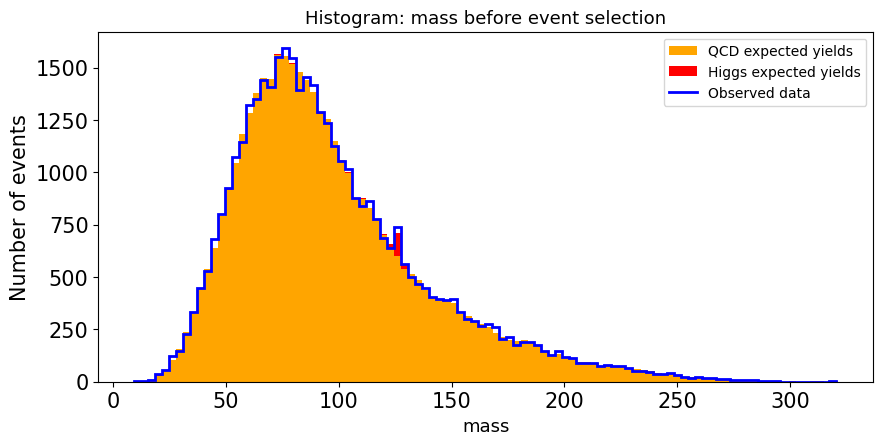

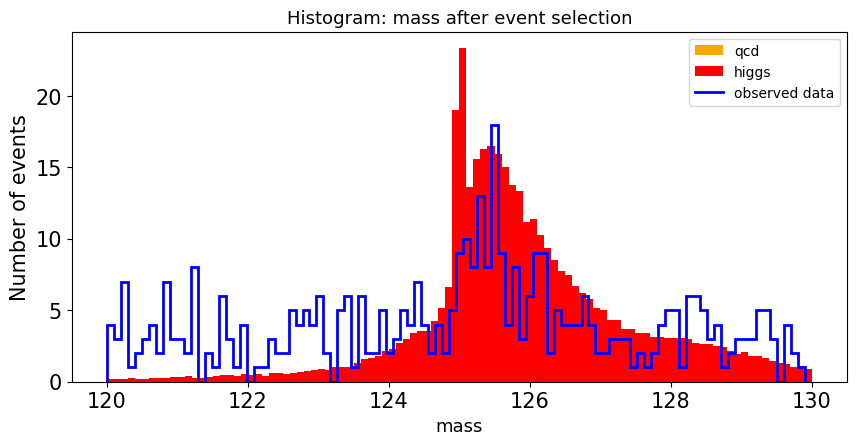

In [86]:
plot_comp(highLumi, 'mass')

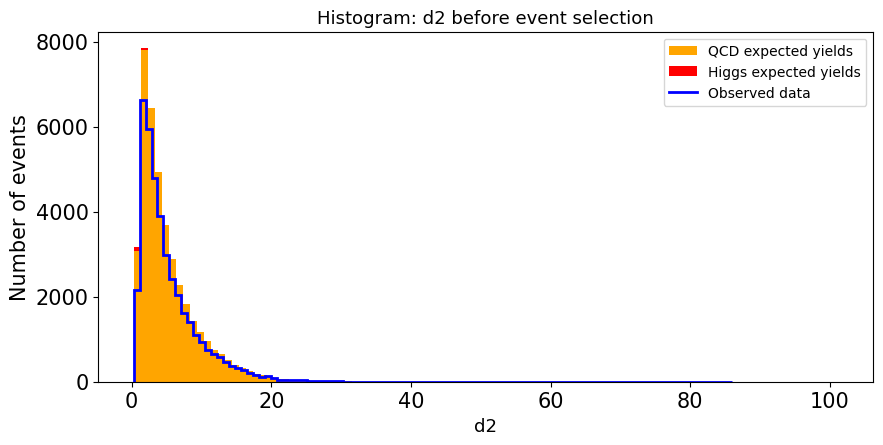

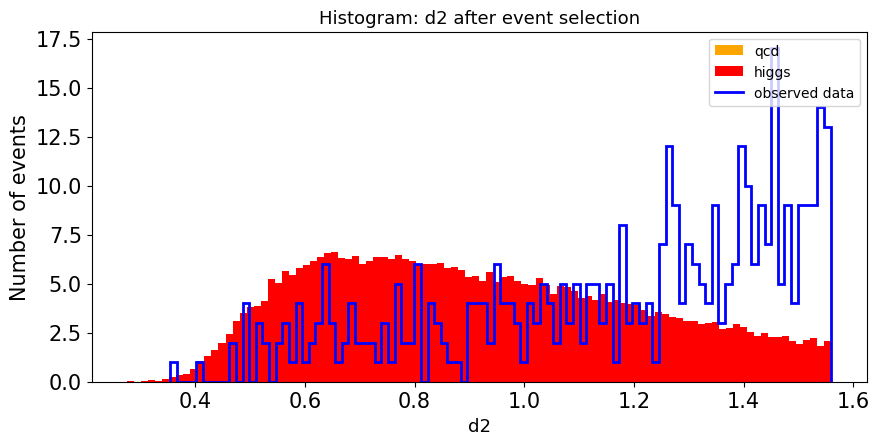

In [87]:
plot_comp(highLumi, 'd2')

- Evaluate observed significance (after splitting) and compare your results to expectation.
For mass and d2 each: We will count the # of events left in observed data after event selection, and calculate this significance by compare it to 

## Part 2
Low luminosity data
- Do as before with the high luminosity data and comment on the difference.

## Part 3
95% Confidence Level of signal yields
- In the low luminosity data, the observed significance is less than 5 σ . We will calculate the 95% confidence level upper limit of signal yield.
- Evaluate the expected 95% confidence level upper limit
- Evaluate the observed 95% confidence level upper limit
- Compare expectation to observation. Comment on your finding.

## Part 4, Bonus:
Evalute the 1 σ  uncertainty of the expected 95% confidence level upper limit.